In [1]:
import torch
import torchaudio
import os
import shutil
import random
import librosa

In [2]:
!pip install pydub

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/holehe-1.61-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
# Define root directory
root_dir = '/tmp/GTZAN'
source_dir=os.getcwd()+'/../../data/Data/genres_original'


if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(tmp_path,SOURCE_DIR):
    """
    Creates directories for the train and test sets

    Args:
    tmp_path (string) - the base directory path to create subdirectories from

    Returns:
    None
    """

    ### START CODE HERE

    # HINT:
    # Use os.makedirs to create your directories with intermediate subdirectories
    # Don't hardcode the paths. Use os.path.join to append the new directories to the tmp_path parameter


    tmp_path_training = os.path.join(tmp_path, 'training')
    tmp_path_validation = os.path.join(tmp_path, 'validation')
    tmp_path_test = os.path.join(tmp_path, 'test')
    
    os.makedirs(tmp_path_training)
    os.makedirs(tmp_path_validation)
    os.makedirs(tmp_path_test)
    """
    for repertory in os.listdir(SOURCE_DIR):
        
        repertory_path = os.path.join(SOURCE_DIR, repertory)
        if not os.path.isdir(repertory_path) or repertory == ".DS_Store":
            continue
            
        tmp_path_training_repertory = os.path.join(tmp_path_training, repertory)
        tmp_path_validation_repertory = os.path.join(tmp_path_validation, repertory)
        tmp_path_test_repertory = os.path.join(tmp_path_test, repertory)

        os.makedirs(tmp_path_training_repertory)
        os.makedirs(tmp_path_validation_repertory)
        os.makedirs(tmp_path_test_repertory)"""
        
try:
    create_train_val_dirs(tmp_path=root_dir,SOURCE_DIR=source_dir )
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [4]:
# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/GTZAN/test
/tmp/GTZAN/training
/tmp/GTZAN/validation


In [5]:
root=os.getcwd()+'/../../data/Data/genres_original'

def copy_data_from_source_to(tab_files, SOURCE_DIR, PATH_DIR):
    for file in tab_files:
        source_path = os.path.join(SOURCE_DIR, file)
        destination_path = os.path.join(PATH_DIR, file)

        if os.path.getsize(source_path) > 0 and source_path.endswith(".wav"):
            shutil.copy(source_path, destination_path)
        else:
            print(f"{file} is zero length, so ignoring.")
    print(tab_files[0])
    #pixel_count = get_image_pixel_count(tab_files[0])
    #print( tab_files[0].dtype)

# SPLIT = 80/10/10
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
    all_files = os.listdir(SOURCE_DIR)
    random.shuffle(all_files)

    split_one = int(len(all_files) * 0.8)
    split_two = int(len(all_files) * 0.9)
    
    training_files = all_files[:split_one]
    validation_files = all_files[split_one:split_two]
    test_files = all_files[split_two:]

    copy_data_from_source_to(training_files, SOURCE_DIR, TRAINING_DIR)
    copy_data_from_source_to(validation_files, SOURCE_DIR, VALIDATION_DIR)
    copy_data_from_source_to(test_files, SOURCE_DIR, TEST_DIR)


In [6]:
TEST_DIR= os.path.join( root_dir,os.listdir(root_dir)[0]) 
TRAINING_DIR= os.path.join( root_dir,os.listdir(root_dir)[1])
VALIDATION_DIR= os.path.join( root_dir,os.listdir(root_dir)[2])

print (TEST_DIR)
print (TRAINING_DIR)
print (VALIDATION_DIR)

for rootdir, dirs, files in os.walk(source_dir):
    for subdir in dirs:
        SUB_ROOT_DIR=os.path.join(rootdir, subdir)
        
        split_data(SOURCE_DIR=SUB_ROOT_DIR, TRAINING_DIR=TRAINING_DIR, VALIDATION_DIR=VALIDATION_DIR, TEST_DIR=TEST_DIR)
        
        print(f"Original directory has {len(os.listdir(SUB_ROOT_DIR))} images of ",subdir,"\n")
        
        print(f"There are {len(os.listdir(TRAINING_DIR))} images of ",subdir," for training")
        print(f"There are {len(os.listdir(VALIDATION_DIR))} images of ",subdir," for validation")
        print(f"There are {len(os.listdir(TEST_DIR))} images of ",subdir," for testing")

/tmp/GTZAN/test
/tmp/GTZAN/training
/tmp/GTZAN/validation
pop.00042.wav
pop.00038.wav
pop.00010.wav
Original directory has 100 images of  pop 

There are 80 images of  pop  for training
There are 10 images of  pop  for validation
There are 10 images of  pop  for testing
metal.00063.wav
metal.00035.wav
metal.00058.wav
Original directory has 100 images of  metal 

There are 160 images of  metal  for training
There are 20 images of  metal  for validation
There are 20 images of  metal  for testing
disco.00098.wav
disco.00065.wav
disco.00023.wav
Original directory has 100 images of  disco 

There are 240 images of  disco  for training
There are 30 images of  disco  for validation
There are 30 images of  disco  for testing
blues.00067.wav
blues.00005.wav
blues.00054.wav
Original directory has 100 images of  blues 

There are 320 images of  blues  for training
There are 40 images of  blues  for validation
There are 40 images of  blues  for testing
reggae.00029.wav
reggae.00060.wav
reggae.0004

In [8]:
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim 
import librosa
from pydub import AudioSegment
import numpy as np


label_mapping = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,'jazz': 5,'metal': 6,'pop': 7,'reggae': 8, 'rock': 9 }


"""def convertSongToMatrice(audio_path, size=599):
    y, sr = librosa.load(audio_path)
    win_length=sr/10
    print(sr)

    D = np.abs(librosa.stft(y,win_length=win_length, hop_length=win_lenght/2))# 50 miliseconde pour le  hop size
    spectrogram = librosa.feature.melspectrogram(S=D, sr=sr)
    spectrogram = librosa.util.fix_length(spectrogram,size= size)
    print(spectrogram.shape)
    return spectrogram
"""
def convertSongToMatrice(audio_path, size=599):
    y, sr = librosa.load(audio_path)
    n_fft= (sr/10) /2 +3
    #print(n_fft)
    D = np.abs(librosa.stft(y ,hop_length= int(n_fft)))
    spectrogram = librosa.feature.melspectrogram(S=D, sr=sr)
    #print(spectrogram.shape)
    spectrogram = librosa.util.fix_length(spectrogram,size= size)
    
    return spectrogram

def string_to_label(string, mapping):
    return mapping[string]


def createDataset(files):
    list_Matrice = []
    list_label = []

    for root, dirs, files in os.walk(files):
        for SongName in files:
            audio_path = os.path.join(root, SongName)

            spectrogram = convertSongToMatrice(audio_path)
            spectrogram = torch.tensor(spectrogram)
            # Ajouter la dimension du canal
            spectrogram = spectrogram.unsqueeze(0)
            
            label = string_to_label(SongName.split('.')[0],label_mapping)

            list_Matrice.append(spectrogram)
            list_label.append(label)

    tensor_x = torch.stack(list_Matrice) 
    tensor_y = torch.LongTensor(list_label)
    print ("tensor_x",tensor_x.shape)
    print ("tensor_y",tensor_y.shape)

    dataset = TensorDataset(tensor_x, tensor_y)
    return dataset

def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR, batch_size=32):
    train_dataset = createDataset(TRAINING_DIR)
    validation_dataset = createDataset(VALIDATION_DIR)
    test_dataset = createDataset(TEST_DIR)

    train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_generator = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_generator, validation_generator, test_generator


In [51]:
from torch.utils.data import DataLoader

train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

tensor_x torch.Size([800, 1, 128, 599])
tensor_y torch.Size([800])
tensor_x torch.Size([100, 1, 128, 599])
tensor_y torch.Size([100])
tensor_x torch.Size([99, 1, 128, 599])
tensor_y torch.Size([99])


In [56]:
from torch.nn import Module
import torch.nn.functional as F

class SimpleCNN(Module):
    def __init__(self):
        # call the parent constructor
        super(SimpleCNN, self).__init__()
        
        # Convolutional layer convolution d'une matrice de taille total 128x599 en convolutionnant des layer de taille 128x4 avec un pas de en 0x1 
        # PADDING 4 DIMENSION
        self.norm1 = nn.BatchNorm2d(1) 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(128,4), padding=(0,1))
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(1,4))
        
        # Convolutional layer 2
        self.norm2 = nn.BatchNorm2d(1) 
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size= (256,4)) 
        self.pool2 = nn.MaxPool2d(kernel_size=(1,2))
        
        self.norm3 = nn.BatchNorm2d(1)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=512, kernel_size=(256,4) )
        
        self.norm4 = nn.BatchNorm2d(1) 
        self.conv4 = nn.Conv2d(in_channels=1, out_channels=512, kernel_size=(512,4) )

        
        # Fully connected layers
        self.normfc2 = nn.BatchNorm1d(1536) 
        self.fc2 = nn.Linear(1536, 2048)
        self.normfc3 = nn.BatchNorm1d(2048) 
        self.fc3 = nn.Linear(2048, 2048)
        self.normfc4 = nn.BatchNorm1d(2048) 
        self.fc4 = nn.Linear(2048, 10)
        

    def forward(self, x):
        #print(" input layer :", x.shape)
        
        #print (" first  layer")
        x = self.norm1(x)
        #print(" norm1 :", x.shape)
        x = self.conv1(x)
        #print(" conv1 :", x.shape)
        x = self.relu(x)
        #print(" relu :", x.shape)
        x = self.pool1(x)
        #print(" pool1 :", x.shape)
        x = torch.permute(x,(0,2,1,3))
        #print(" permute 1 :", x.shape)
        
        #print (" second  layer")
        x = self.norm2(x)
        #print(" norm2 :", x.shape)
        x = self.conv2(x)
        #print(" conv2 :", x.shape)
        x = self.relu(x)
        #print(" relu :", x.shape)
        x = self.pool2(x)
        #print(" pool2 :", x.shape)
        x = torch.permute(x,(0,2,1,3))
        #print(" permute 2 :", x.shape)
        
        
        #print (" third  layer")
        x = self.norm3(x)
        #print(" norm3 :", x.shape)
        x = self.conv3(x)
        #print(" conv3 :", x.shape)
        x = self.relu(x)
        #print(" relu :", x.shape)
        x = self.pool2(x)
        #print(" pool2 :", x.shape)
        x = torch.permute(x,(0,2,1,3))
        #print(" permute 3 :", x.shape)
        
        #print (" four bis  layer")
        x = self.norm4(x)
        #print(" norm4 :", x.shape)
        x = self.conv4(x)
        #print(" conv4 :", x.shape)
        x = self.relu(x)
        #print(" relu :", x.shape)
        x = torch.permute(x,(0,2,1,3))
        #print(" permute 4 :", x.shape)
        
        #print (" five sub layer ")
        mean_values = torch.mean(x, dim=3, keepdim=True)
        #print(mean_values.shape)
        max_values, _ = torch.max(x, dim=3, keepdim=True)
        #print(max_values.shape)
        l2_norm = torch.linalg.norm(x, dim=3, ord= 2, keepdim=True)
        #print(l2_norm.shape)
        
        #print (" five  layer ")
        x = torch.cat([max_values, mean_values, l2_norm], dim=1)  # Concaténer sur la dimension 1
        #print (" Global Temporal pooling", x.shape)
        
        
        x = x.view(-1, 1536)
        #print (" six  layer ")
        x = self.normfc2(x)
        #print(" normfc2 :", x.shape)
        x = self.fc2(x)
        #print (" fc2 ", x.shape)
        x = F.relu(x)
        #print (" relu ", x.shape)
        
        #print (" six  layer ")
        x = self.normfc3(x)
        #print(" normfc3 :", x.shape)
        x = self.fc3(x)
        #print (" fc3 ", x.shape)
        x = F.relu(x)
        #print (" relu ", x.shape)
        
        #print (" six  layer ")
        x = self.normfc4(x)
        #print(" normfc4 :", x.shape)
        x = self.fc4(x)
        #print (" fc4 ", x.shape)
        #x = F.softmax(x, dim=1)
        #print (" output layer ", x.shape)
        
        return x

In [57]:
def trainModel(model, criterion, optimizer, dataset):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(dataset):
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #print("outputs",outputs)
        #print("labels",labels)
        loss = criterion(outputs, labels)
        #print("loss",loss)
        #print()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = running_loss / len(dataset)
    return accuracy, average_loss

In [58]:
def ValidatModel(model, criterion, optimizer, dataset):
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    for data in dataset:
        inputs, labels = data
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()
        
        _, val_predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (val_predicted == labels).sum().item()
        
    val_accuracy = val_correct / val_total
    val_average_loss = val_running_loss / len(dataset)
    
    return val_accuracy,val_average_loss

Pour afficher le tensorboard il faut excuter 'tensorboard --logdir=runs' dans le repertoire ou il y a le fichier runs
Puis aller sur l'url : http://localhost:6006/

In [59]:
from torch.utils.tensorboard import SummaryWriter
import time
from torch.optim.lr_scheduler import LambdaLR

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
lambda1 = lambda epoch: 10**(epoch/10)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])

tabLearningRate=[]
tabLoss=[]

epoch=0
while(optimizer.param_groups[0]["lr"]<1 and optimizer.param_groups[0]["lr"]!= None):
    accuracy, average_loss = trainModel(model, criterion, optimizer, train_generator)
    scheduler.step()

    tabLearningRate+= [optimizer.param_groups[0]["lr"]]
    tabLoss+=[average_loss]
    

    print(f'Epoch {epoch} - '
          f'Accuracy: {accuracy:.4f} - '
          f'Average Loss: {average_loss:.4f} - '
          f'Learning Rate: {optimizer.param_groups[0]["lr"]:}')
    epoch+=1

Epoch 0 - Accuracy: 0.1075 - Average Loss: 2.4661 - Learning Rate: 1.2589254117941673e-05
Epoch 1 - Accuracy: 0.2825 - Average Loss: 2.0179 - Learning Rate: 1.5848931924611138e-05
Epoch 2 - Accuracy: 0.4200 - Average Loss: 1.7534 - Learning Rate: 1.9952623149688796e-05
Epoch 3 - Accuracy: 0.4813 - Average Loss: 1.5889 - Learning Rate: 2.5118864315095805e-05
Epoch 4 - Accuracy: 0.5537 - Average Loss: 1.4371 - Learning Rate: 3.1622776601683795e-05
Epoch 5 - Accuracy: 0.6288 - Average Loss: 1.2750 - Learning Rate: 3.981071705534973e-05
Epoch 6 - Accuracy: 0.6913 - Average Loss: 1.1428 - Learning Rate: 5.0118723362727224e-05
Epoch 7 - Accuracy: 0.7325 - Average Loss: 1.0105 - Learning Rate: 6.309573444801933e-05
Epoch 8 - Accuracy: 0.7775 - Average Loss: 0.9047 - Learning Rate: 7.943282347242817e-05
Epoch 9 - Accuracy: 0.8187 - Average Loss: 0.7818 - Learning Rate: 0.0001
Epoch 10 - Accuracy: 0.8337 - Average Loss: 0.6988 - Learning Rate: 0.00012589254117941674
Epoch 11 - Accuracy: 0.8488 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


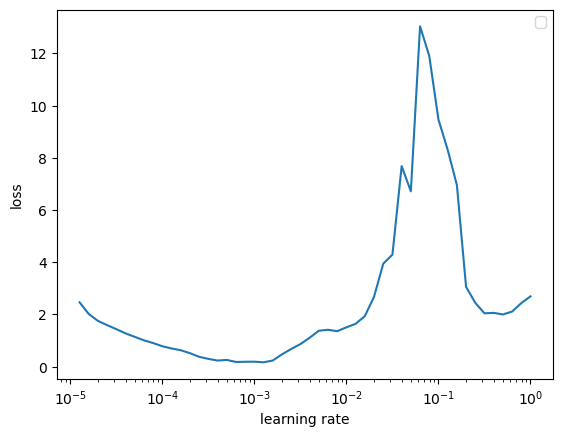

In [60]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(tabLearningRate, tabLoss)
plt.xlabel('learning rate')
plt.xscale('log')
plt.ylabel('loss')
plt.legend()

plt.show()

In [61]:
min_y = min(tabLoss)
min_index = tabLoss.index(min_y)

LearningRate = tabLearningRate[min_index]
print('best LearningRate:',LearningRate)
#best LearningRate: 0.0008912509381337458

best LearningRate: 0.0012589254117941677


In [62]:
from torch.utils.tensorboard import SummaryWriter
import time

#LearningRate = 0.0008912509381337458
num_epochs=30

model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LearningRate)

writer = SummaryWriter()
for epoch in range(num_epochs):
    start_time = time.time()
    accuracy_train, loss_train = trainModel(model, criterion, optimizer, train_generator)
    epoch_time_train = time.time() - start_time

    # Ajouter les métriques à TensorBoard
    writer.add_scalar('Loss/train', loss_train, epoch)
    writer.add_scalar('Accuracy/train', accuracy_train, epoch)
    
    start_time = time.time()
    accuracy_val,loss_val = ValidatModel(model, criterion, optimizer, validation_generator)
    epoch_time_val = time.time() - start_time
        
    writer.add_scalar('Loss/val', loss_val, epoch)
    writer.add_scalar('Accuracy/val', accuracy_val, epoch)
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
      f'Loss: {loss_train:.4f} - Accuracy: {accuracy_train:.4f} - '
      f'Time: {epoch_time_train:.2f} seconds - '
      f'Val Loss: {loss_val:.4f} - Val Accuracy: {accuracy_val:.4f} - '
      f'Time: {epoch_time_val:.2f} seconds')
writer.close()

Epoch 1/100 - Loss: 1.7758 - Accuracy: 0.3812 - Time: 3.35 seconds - Val Loss: 1.4244 - Val Accuracy: 0.5800 - Time: 0.20 seconds
Epoch 2/100 - Loss: 1.1864 - Accuracy: 0.6362 - Time: 3.45 seconds - Val Loss: 1.3626 - Val Accuracy: 0.6100 - Time: 0.19 seconds
Epoch 3/100 - Loss: 0.9281 - Accuracy: 0.7412 - Time: 3.51 seconds - Val Loss: 1.2638 - Val Accuracy: 0.6700 - Time: 0.20 seconds
Epoch 4/100 - Loss: 0.7729 - Accuracy: 0.8075 - Time: 3.57 seconds - Val Loss: 1.1507 - Val Accuracy: 0.6800 - Time: 0.19 seconds
Epoch 5/100 - Loss: 0.6011 - Accuracy: 0.8750 - Time: 3.66 seconds - Val Loss: 1.1537 - Val Accuracy: 0.6600 - Time: 0.17 seconds
Epoch 6/100 - Loss: 0.5292 - Accuracy: 0.8938 - Time: 3.69 seconds - Val Loss: 1.1518 - Val Accuracy: 0.6900 - Time: 0.19 seconds
Epoch 7/100 - Loss: 0.4246 - Accuracy: 0.9237 - Time: 3.53 seconds - Val Loss: 1.1521 - Val Accuracy: 0.7100 - Time: 0.18 seconds
Epoch 8/100 - Loss: 0.3837 - Accuracy: 0.9325 - Time: 3.70 seconds - Val Loss: 1.0908 - Va

KeyboardInterrupt: 

In [63]:
classes = ('blues', 'classical', 'country', 'disco', 'hiphop','jazz','metal','pop','reggae', 'rock')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in validation_generator:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: blues is 70.0 %
Accuracy for class: classical is 100.0 %
Accuracy for class: country is 70.0 %
Accuracy for class: disco is 70.0 %
Accuracy for class: hiphop is 60.0 %
Accuracy for class: jazz  is 70.0 %
Accuracy for class: metal is 100.0 %
Accuracy for class: pop   is 90.0 %
Accuracy for class: reggae is 50.0 %
Accuracy for class: rock  is 60.0 %


In [64]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_generator:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 100 test images: {100 * correct // total} %')

Accuracy of the network on the 100 test images: 61 %
